## Importation des librairies 

In [92]:
from tqdm.notebook import tqdm
from importlib import reload
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time

from utilitaires import psnr_from_model, load_data, train_model, function_for_comparison, plot_result, affiche_images
from Models_Architectures import SUNet
#from Models_Architectures.SUNet import SUNet
reload(SUNet)

ModuleNotFoundError: spec not found for the module 'Models_Architectures.SUNet'

## Parameters

In [76]:
CT = False               # Training with CT data or not
upscale = 2                     # Upscale factor (U) = 4
window_size = 16                 # Window size (W)
patch_size = 4 
embed_dim = 96                  # Embedding dimension (D) = 96
num_heads = [3, 6]             # Default chosen in the document [3,6,12,24]
depths = [6,6]                        # Number of encoder layers (L) = 4
input_channels = 1                 # Number of channels for input images
input_size = 64  
shift_size = window_size // 2   #  Shift size (S)
num_features = 64   
mlp_ratio = 2.  


epochs = 100             # Number of epochs
base_lr = 8e-4          # Base LR
batch_size = 64         # Penser à rendre le 64 normal
loss_fn = nn.L1Loss()
save_path = f'./Saved_models/model_sunet_{epochs}epochs_{window_size}windowsize.pth'


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_channels = 2 if CT else 1  # Number of channels for input images
print("Device :", device)
print("Channel number :", n_channels)
print(save_path)

Device : cpu
Channel number : 1
./Saved_models/model_sunet_100epochs_16windowsize.pth


## Import data

In [77]:
# Download data
type_data = ["low_edep", "high_edep", "ct"]
low_samp_data = load_data("MCsimulations", type_data[0])
high_samp_data = load_data("MCsimulations", type_data[1])
if CT:
    ct_data = load_data("MCsimulations", type_data[2])

# Transform data into tensors
low_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in low_samp_data]
high_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in high_samp_data]
if CT:
    ct_tensors = [torch.from_numpy(x).to(torch.float32) for x in ct_data]

../data/MCsimulations/
6560
../data/MCsimulations/
6560


In [78]:
import random

# List of patient indices from 1 to 82
index_patients = list(range(0, 82))

# Set the random seed for reproducibility
random.seed(1)

# Shuffle the list of patient indices
random.shuffle(index_patients)

# Assign indices to training, validation, and test sets
train_index = index_patients[:58]
val_index = index_patients[58:58+16]
test_index = index_patients[58+16:]

# Initialize lists to store training, validation, and test data
Low_train = []
High_train = []
CT_train = []

Low_val = []
High_val = []
CT_val = []

Low_test = []
High_test = []
CT_test = []

# Populate training data
for i in train_index:
    Low_train.extend(low_samp_tensors[i*80: (i+1)*80])
    High_train.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_train.extend(ct_tensors[i*80: (i+1)*80])

# Populate validation data
for i in val_index:
    Low_val.extend(low_samp_tensors[i*80: (i+1)*80])
    High_val.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_val.extend(ct_tensors[i*80: (i+1)*80])

# Populate test data
for i in test_index:
    Low_test.extend(low_samp_tensors[i*80: (i+1)*80])
    High_test.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_test.extend(ct_tensors[i*80: (i+1)*80])

print(f"The train data size is : {len(Low_train)}")
print(f"The validation data size is : {len(Low_val)}")
print(f"The test data size is : {len(Low_test)}")

The train data size is : 4640
The validation data size is : 1280
The test data size is : 640


In [79]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, low, high, ct=None):
        self.low = low
        self.high = high
        self.ct = ct

    def __len__(self):
        return len(self.low)

    def __getitem__(self, idx):
        X = self.low[idx]
        y = self.high[idx]
        
        if self.ct is not None:
            X = torch.stack([self.low[idx], self.ct[idx]], dim=0)
        
        return X, y
    
# DataLoader
if CT:
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train, CT_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val, CT_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test, CT_test),
                                batch_size=batch_size, shuffle=True)
else :
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test),
                                batch_size=batch_size, shuffle=True)

## Train SUNet

In [80]:
# Def the model
reload(SUNet)
model_sunet = SUNet.SUNet(img_size=input_size, patch_size=patch_size, input_channels=input_channels, 
                    out_chans=input_channels, embed_dim=embed_dim, depths=depths,
                    num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio, 
                    qkv_bias=True, qk_scale=2, drop_rate=0., attn_drop_rate=0., 
                    drop_path_rate=0.1, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                    use_checkpoint=False, final_upsample="Dual up-sample")
model_sunet.to(device)

# Optimiser
optimizer = torch.optim.Adam(model_sunet.parameters(), lr=base_lr)

print('FLOPs: %.4f G' % (model_sunet.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet.parameters())))
print('Models parameters : ', model_sunet)

FLOPs: 0.3544 G
Number of parameters: 3315917
Models parameters :  SUNet(
  (prelu): PReLU(num_parameters=1)
  (conv_first): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (proj): Conv2d(96, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(16, 16), depth=6
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(16, 16), num_heads=3, window_size=16, shift_size=0, mlp_ratio=2.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(16, 16), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, 

In [ ]:
start = time.time()

# Model training
model_sunet, loss_train, loss_val = train_model(
    model=model_sunet,
    criterion=loss_fn, 
    optimizer=optimizer,
    dataloaders={'train' : dataloader_train, 'val' : dataloader_val},
    device=device,
    n_epochs=epochs, 
    save_path=save_path,
)

end = time.time() - start

torch.save(model_sunet.state_dict(), save_path)

Epoch 1
-------------------------------------------------
Training done !!! 
 Evaluation 


In [82]:
end

16429.07471394539

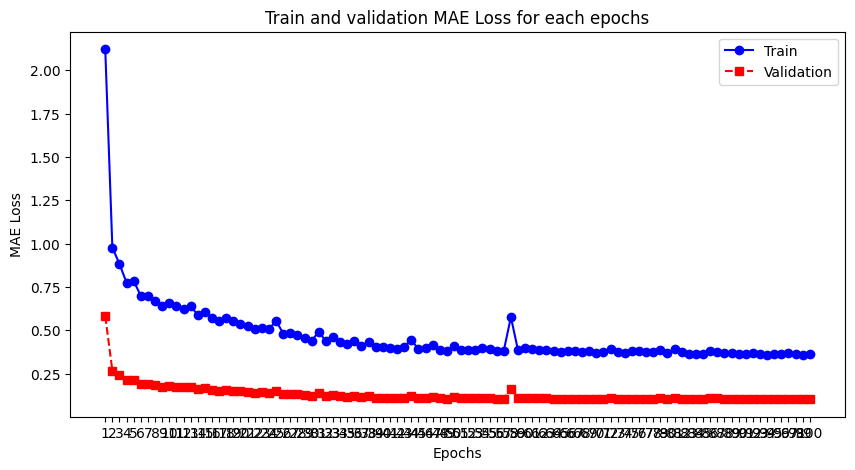

In [83]:
# Evolution of the training
plot_result(loss_train, loss_val, "MAE Loss")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/id2180/pfe-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_26693/842595828.py", line 4, in <module>
    function_for_comparison(model_path=path_to_load,
  File "/home/id2180/pfe-repository/utilitaires.py", line 125, in function_for_comparison
  File "/home/id2180/pfe-repository/utilitaires.py", line 88, in affiche_images
    plt.xlabel('Low Sampling',fontweight='bold')
  File "/home/id2180/pfe-venv/lib/python3.11/site-packages/matplotlib/pyplot.py", line 3343, in imshow
    __ret = gca().imshow(
            ^^^^^^^^^^^^^
  File "/home/id2180/pfe-venv/lib/python3.11/site-packages/matplotlib/__init__.py", line 1465, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/id2180/pfe-venv/lib/python3.11/site-packages/matplotlib/axes/_a

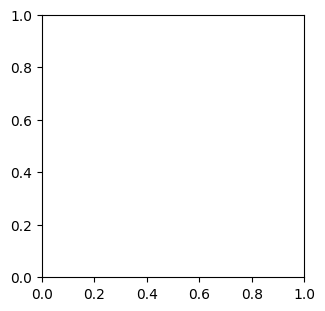

In [84]:
path_to_load = save_path

# Chargement du modèle et représentation graphique des résultats
function_for_comparison(model_path=path_to_load, 
                        dataloader = dataloader_test, 
                        ind = 20, 
                        model = model_sunet)

In [85]:
 model = model_sunet
model.load_state_dict(torch.load(save_path))
model.eval()


SUNet(
  (prelu): PReLU(num_parameters=1)
  (conv_first): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (proj): Conv2d(96, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(16, 16), depth=6
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(16, 16), num_heads=3, window_size=16, shift_size=0, mlp_ratio=2.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(16, 16), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
 

In [87]:
for X, y in dataloader_test:
    with torch.no_grad():
        result = model(X)
    data = X
    label = y
    break


torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])


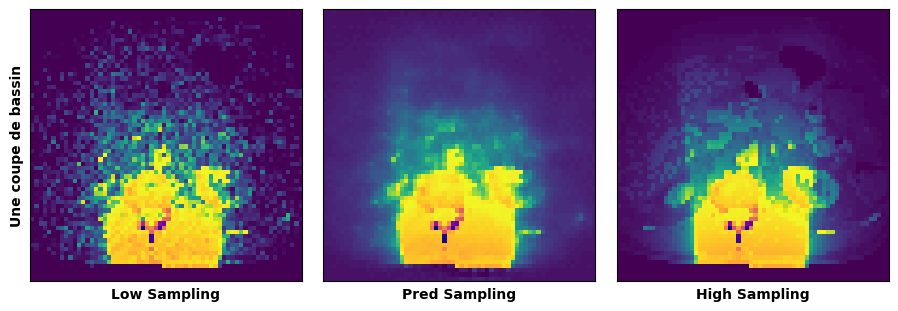

In [90]:
ind = 0
low_im = data[ind, :, :]
pred_im = result[ind, :, :]
high_im = label[ind, :, :]
low_im.squeeze_(0)
print(low_im.shape)
print(pred_im.shape)
print(high_im.shape)
affiche_images(low_image=low_im, pred_image=pred_im, high_image=high_im)